#### Целочисленное линейное программирование
метод ветвей и границ интерактивно

$$
\begin{aligned}
& \text{F} = 2x_1 + 5x_2 \to \max \\
& \begin{cases}
3x_1 + 2x_2 \leq 8 \\
x_1 + 4x_2 \leq 9 \\
3x_1 + x_2 \leq 7 \\
x_1, x_2 \geq 0
\end{cases}
\end{aligned}
$$

Solving
------------------------------------------------------------
Step 1: Solving the relaxed LP problem
Relaxed solution: x1 = 1.4, x2 = 1.9, F = 12.3

Iteration 1: Exploring Root
Bounds: x1 ∈ [0, ∞], x2 ∈ [0, ∞]
Solution: x1 = 1.4, x2 = 1.9, F = 12.3
Branching on x1 = 1.4

Iteration 2: Exploring Node 1a: x1 ≤ 1
Bounds: x1 ∈ [0, 1], x2 ∈ [0, ∞]
Solution: x1 = 1.0, x2 = 2.0, F = 12.0
Found integer solution!
New best solution: x1 = 1, x2 = 2, F = 12.0

Iteration 3: Exploring Node 1b: x1 ≥ 2
Bounds: x1 ∈ [2, ∞], x2 ∈ [0, ∞]
Solution: x1 = 2.0, x2 = 1.0, F = 9.0
Pruning: This branch cannot improve upon current best value 12.0

Branch and Bound completed.

Final optimal integer solution:
x₁ = 1
x₂ = 2
Maximum value F = 12.0


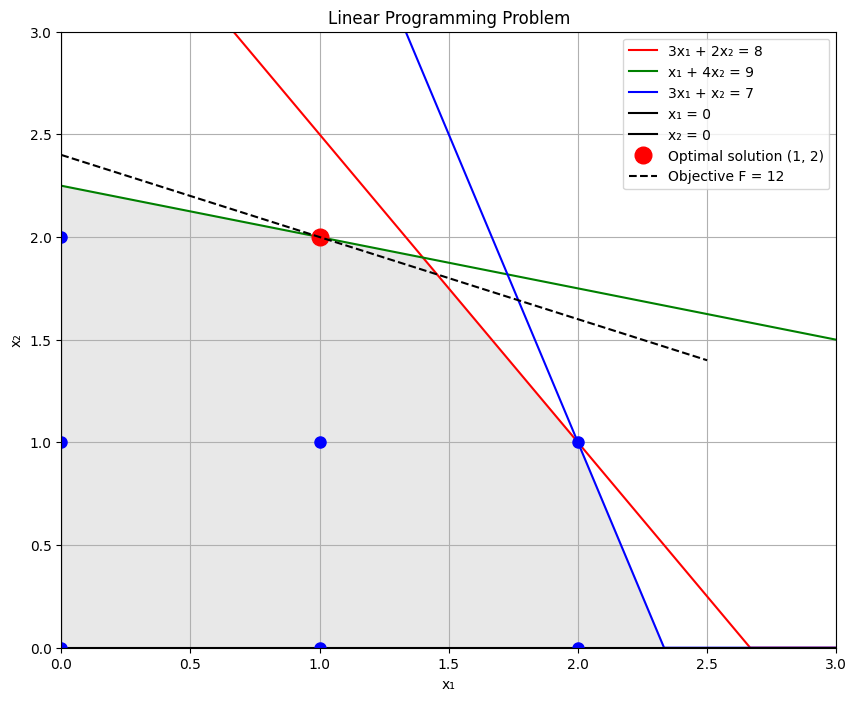

In [20]:
import pulp
import numpy as np
import matplotlib.pyplot as plt

def solve_relaxed_lp(x1_lb=0, x1_ub=None, x2_lb=0, x2_ub=None):
    prob = pulp.LpProblem("Exercise_22_1", pulp.LpMaximize)
    
    x1 = pulp.LpVariable("x1", lowBound=x1_lb, upBound=x1_ub)
    x2 = pulp.LpVariable("x2", lowBound=x2_lb, upBound=x2_ub)
    
    prob += 2 * x1 + 5 * x2
    
    prob += 3 * x1 + 2 * x2 <= 8, "Constraint 1"
    prob += x1 + 4 * x2 <= 9, "Constraint 2"
    prob += 3 * x1 + x2 <= 7, "Constraint 3"
    
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    
    if prob.status == pulp.LpStatusOptimal:
        return {
            "x1": x1.value(),
            "x2": x2.value(),
            "obj": pulp.value(prob.objective)
        }
    else:
        return None

def branch_and_bound():
    print("Step 1: Solving the relaxed LP problem")
    solution = solve_relaxed_lp()
    
    if solution is None:
        print("The problem is infeasible.")
        return None
    
    print(f"Relaxed solution: x1 = {solution['x1']}, x2 = {solution['x2']}, F = {solution['obj']}")
    
    if solution['x1'].is_integer() and solution['x2'].is_integer():
        print("The relaxed solution is already integer. No branching needed.")
        return {
            "x1": int(solution['x1']),
            "x2": int(solution['x2']),
            "obj": solution['obj']
        }
    
    best_solution = None
    best_value = float('-inf')
    nodes = [(0, None, 0, None, "Root")]  # (x1_lower, x1_upper, x2_lower, x2_upper, node_name)
    
    iteration = 1
    
    while nodes:
        x1_lb, x1_ub, x2_lb, x2_ub, node_name = nodes.pop(0)
        
        print(f"\nIteration {iteration}: Exploring {node_name}")
        print(f"Bounds: x1 ∈ [{x1_lb}, {'∞' if x1_ub is None else x1_ub}], " +
              f"x2 ∈ [{x2_lb}, {'∞' if x2_ub is None else x2_ub}]")
        
        # Solve subproblem
        solution = solve_relaxed_lp(x1_lb, x1_ub, x2_lb, x2_ub)
        
        if solution is None:
            print("This subproblem is infeasible. Pruning...")
            iteration += 1
            continue
        
        print(f"Solution: x1 = {solution['x1']}, x2 = {solution['x2']}, F = {solution['obj']}")
        
        # Check if this solution can be pruned
        if best_solution and solution['obj'] <= best_value:
            print(f"Pruning: This branch cannot improve upon current best value {best_value}")
            iteration += 1
            continue
        
        # Check if solution is integer
        if solution['x1'].is_integer() and solution['x2'].is_integer():
            print("Found integer solution!")
            if best_solution is None or solution['obj'] > best_value:
                best_solution = {
                    "x1": int(solution['x1']),
                    "x2": int(solution['x2']),
                    "obj": solution['obj']
                }
                best_value = solution['obj']
                print(f"New best solution: x1 = {best_solution['x1']}, x2 = {best_solution['x2']}, F = {best_solution['obj']}")
            iteration += 1
            continue
        
        # Branch on the variable with largest fractional part
        x1_frac = abs(solution['x1'] - round(solution['x1']))
        x2_frac = abs(solution['x2'] - round(solution['x2']))
        
        if x1_frac >= x2_frac:
            # Branch on x1
            branch_val = solution['x1']
            floor_val = int(branch_val)
            print(f"Branching on x1 = {branch_val}")
            
            # Add left branch (x1 ≤ floor(branch_val))
            nodes.append((x1_lb, floor_val, x2_lb, x2_ub, f"Node {iteration}a: x1 ≤ {floor_val}"))
            
            # Add right branch (x1 ≥ ceil(branch_val))
            nodes.append((floor_val + 1, x1_ub, x2_lb, x2_ub, f"Node {iteration}b: x1 ≥ {floor_val + 1}"))
        else:
            # Branch on x2
            branch_val = solution['x2']
            floor_val = int(branch_val)
            print(f"Branching on x2 = {branch_val}")
            
            # Add left branch (x2 ≤ floor(branch_val))
            nodes.append((x1_lb, x1_ub, x2_lb, floor_val, f"Node {iteration}a: x2 ≤ {floor_val}"))
            
            # Add right branch (x2 ≥ ceil(branch_val))
            nodes.append((x1_lb, x1_ub, floor_val + 1, x2_ub, f"Node {iteration}b: x2 ≥ {floor_val + 1}"))
        
        iteration += 1
    
    print("\nBranch and Bound completed.")
    return best_solution

def plot_solution():
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Define the range of x and y
    x = np.linspace(0, 3, 100)
    
    # Plot the constraints
    y1 = (8 - 3*x) / 2  # 3x₁ + 2x₂ ≤ 8
    y2 = (9 - x) / 4    # x₁ + 4x₂ ≤ 9
    y3 = 7 - 3*x        # 3x₁ + x₂ ≤ 7
    
    # Get only non-negative values
    ax.plot(x, np.maximum(y1, 0), 'r-', label='3x₁ + 2x₂ = 8')
    ax.plot(x, np.maximum(y2, 0), 'g-', label='x₁ + 4x₂ = 9')
    ax.plot(x, np.maximum(y3, 0), 'b-', label='3x₁ + x₂ = 7')
    ax.plot([0, 0], [0, 5], 'k-', label='x₁ = 0')
    ax.plot([0, 5], [0, 0], 'k-', label='x₂ = 0')
    
    # Fill the feasible region
    y_min = np.zeros_like(x)
    y_max = np.minimum(np.minimum(y1, y2), y3)
    y_max[y_max < 0] = 0
    ax.fill_between(x, y_min, y_max, color='lightgray', alpha=0.5)
    
    # Plot integer points in feasible region
    for i in range(3):
        for j in range(3):
            if 3*i + 2*j <= 8 and i + 4*j <= 9 and 3*i + j <= 7:
                ax.plot(i, j, 'bo', markersize=8)
    
    # Plot the optimal solution
    opt_x, opt_y = 1, 2
    ax.plot(opt_x, opt_y, 'ro', markersize=12, label='Optimal solution (1, 2)')
    
    # Draw objective function line
    obj_x = np.array([0, 2.5])
    obj_y = (12 - 2*obj_x) / 5  # F = 2x₁ + 5x₂ = 12
    ax.plot(obj_x, obj_y, 'k--', label='Objective F = 12')
    
    # Set labels, title, and legend
    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')
    ax.set_title('Linear Programming Problem')
    ax.grid(True)
    ax.legend()
    ax.set_xlim(0, 3)
    ax.set_ylim(0, 3)
    
    plt.savefig('lp_solution.png')
    plt.show()

print("Solving")
print("-" * 60)

solution = branch_and_bound()

if solution:
    print(f"\nFinal optimal integer solution:")
    print(f"x₁ = {solution['x1']}")
    print(f"x₂ = {solution['x2']}")
    print(f"Maximum value F = {solution['obj']}")
    
    plot_solution()
else:
    print("No feasible integer solution exists.")

In [21]:
import numpy as np
import pandas as pd
from pulp import *

cities = ['Гомель', 'Гродно', 'Брест', 'Минск']
military_bases = ['Барановичи', 'Слоним', 'Боровка']

# Количество отчисленных студентов (предложение)
supply = {
    'Гомель': 90,
    'Гродно': 70,
    'Брест': 90,
    'Минск': 120
}

# Количество мест в войсках (спрос)
demand = {
    'Барановичи': 100,  # ПВО
    'Слоним': 120,      # ССО
    'Боровка': 150      # Артиллерия
}


costs = {
    'Гомель': {'Барановичи': 408, 'Слоним': 477, 'Боровка': 380},
    'Гродно': {'Барановичи': 189, 'Слоним': 134, 'Боровка': 435},
    'Брест': {'Барановичи': 209, 'Слоним': 199, 'Боровка': 528},
    'Минск': {'Барановичи': 147, 'Слоним': 197, 'Боровка': 167}
}

prob = LpProblem("Student_Transportation_Problem", LpMinimize)

x = LpVariable.dicts("route", 
                     [(i, j) for i in cities for j in military_bases], 
                     lowBound=0, 
                     cat='Integer')

prob += lpSum([x[(i, j)] * costs[i][j] for i in cities for j in military_bases])

for i in cities:
    prob += lpSum([x[(i, j)] for j in military_bases]) == supply[i], f"Supply_{i}"

for j in military_bases:
    prob += lpSum([x[(i, j)] for i in cities]) == demand[j], f"Demand_{j}"

prob.solve()


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/user/3course/operation-research/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/f51aa3729daa43af902c75c67df0e8fc-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/f51aa3729daa43af902c75c67df0e8fc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 12 COLUMNS
At line 73 RHS
At line 81 BOUNDS
At line 94 ENDATA
Problem MODEL has 7 rows, 12 columns and 24 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 80730 - 0.00 seconds
Cgl0004I processed model has 7 rows, 12 columns (12 integer (0 of which binary)) and 24 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0012I Integer solution of 80730 found by greedy equality after 0 iterations and 0 nodes (0.00 seconds)
Cbc0001I Search completed - best objective 80730, took 0 iterations and

1

In [22]:

print(f"Статус: {LpStatus[prob.status]}")
print(f"Общая стоимость транспортировки: {value(prob.objective)}")
print("\nРаспределение студентов:")

results = np.zeros((len(cities), len(military_bases)), dtype=int)
for i, city in enumerate(cities):
    for j, base in enumerate(military_bases):
        results[i, j] = int(value(x[(city, base)]))


df_results = pd.DataFrame(results, index=cities, columns=military_bases)
print(df_results)


df_results['Всего отправлено'] = df_results.sum(axis=1)
df_results.loc['Всего получено'] = df_results.sum(axis=0)
print("\nИтоговая таблица с проверкой баланса:")
print(df_results)


total_cost_breakdown = pd.DataFrame(index=cities, columns=military_bases)
for i, city in enumerate(cities):
    for j, base in enumerate(military_bases):
        students = int(value(x[(city, base)]))
        cost_per_unit = costs[city][base]
        total_cost = students * cost_per_unit
        total_cost_breakdown.iloc[i, j] = f"{students} × {cost_per_unit} = {total_cost}"

print("\nДетализация стоимости (количество × расстояние = стоимость):")
print(total_cost_breakdown)

Статус: Optimal
Общая стоимость транспортировки: 80730.0

Распределение студентов:
        Барановичи  Слоним  Боровка
Гомель           0       0       90
Гродно           0      70        0
Брест           40      50        0
Минск           60       0       60

Итоговая таблица с проверкой баланса:
                Барановичи  Слоним  Боровка  Всего отправлено
Гомель                   0       0       90                90
Гродно                   0      70        0                70
Брест                   40      50        0                90
Минск                   60       0       60               120
Всего получено         100     120      150               370

Детализация стоимости (количество × расстояние = стоимость):
             Барановичи           Слоним           Боровка
Гомель      0 × 408 = 0      0 × 477 = 0  90 × 380 = 34200
Гродно      0 × 189 = 0  70 × 134 = 9380       0 × 435 = 0
Брест   40 × 209 = 8360  50 × 199 = 9950       0 × 528 = 0
Минск   60 × 147 = 8820     

In [23]:
import numpy as np
import pandas as pd
from pulp import *

# Определение специальностей и предприятий
specialties = ['РФ', 'ФЭ', 'АРиСТ', 'КБ', 'ПИ']
companies = ['АГАТ', 'ЛЭТЦ', 'Пеленг', 'Белинтерсат', 'Интеграл', 'IBA']

# Количество студентов каждой специальности
supply = {
    'РФ': 50,    # Радиофизика
    'ФЭ': 30,    # Физическая электроника
    'АРиСТ': 20, # Аэрокосмос
    'КБ': 45,    # Компьютерная безопасность
    'ПИ': 50     # Прикладная информатика
}

# Количество мест в компаниях
demand = {
    'АГАТ': 20,
    'ЛЭТЦ': 30,
    'Пеленг': 40,
    'Белинтерсат': 10,
    'Интеграл': 40,
    'IBA': 15
}

# Приоритеты компаний (матрица приоритетов)
# Чем ниже число, тем выше приоритет (1 = самый высокий)
priorities = {
    'АГАТ': {'КБ': 1, 'РФ': 2, 'ПИ': 3, 'АРиСТ': 4, 'ФЭ': 5},
    'ЛЭТЦ': {'РФ': 1, 'ФЭ': 2, 'КБ': 3, 'ПИ': 4, 'АРиСТ': 5},
    'Пеленг': {'РФ': 1, 'ФЭ': 2, 'ПИ': 3, 'КБ': 4, 'АРиСТ': 5},
    'Белинтерсат': {'АРиСТ': 1, 'РФ': 2, 'ПИ': 3, 'КБ': 4, 'ФЭ': 5},
    'Интеграл': {'ФЭ': 1, 'РФ': 2, 'ПИ': 3, 'КБ': 4, 'АРиСТ': 5},
    'IBA': {'ПИ': 1, 'КБ': 2, 'РФ': 3, 'ФЭ': 4, 'АРиСТ': 5}
}

# Создаем модель
prob = LpProblem("Student_Internship_Assignment", LpMinimize)

# Создаем переменные решения
x = LpVariable.dicts("assignment", 
                     [(s, c) for s in specialties for c in companies], 
                     lowBound=0, 
                     cat='Integer')

# Целевая функция: минимизировать издержки (приоритеты)
# Чем выше приоритет (меньше число), тем ниже издержки
prob += lpSum([x[(s, c)] * priorities[c][s] for s in specialties for c in companies])

# Ограничение: количество распределенных студентов каждой специальности не может превышать предложение
for s in specialties:
    prob += lpSum([x[(s, c)] for c in companies]) <= supply[s], f"Supply_{s}"

# Ограничение: количество студентов, распределенных в каждую компанию, должно быть равно спросу компании
for c in companies:
    prob += lpSum([x[(s, c)] for s in specialties]) == demand[c], f"Demand_{c}"

# Решаем задачу
prob.solve()


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/user/3course/operation-research/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/05cb3fdd6bf64073847b53d7748c87e8-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/05cb3fdd6bf64073847b53d7748c87e8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 16 COLUMNS
At line 167 RHS
At line 179 BOUNDS
At line 210 ENDATA
Problem MODEL has 11 rows, 30 columns and 60 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 215 - 0.00 seconds
Cgl0004I processed model has 11 rows, 30 columns (30 integer (0 of which binary)) and 60 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Full problem 11 rows 30 columns, reduced to 0 rows 0 columns
Cbc0012I Integer solution of 215 found by greedy equality after 0 iterations and 0 nodes (0.00 seconds)


1

In [24]:

# Выводим результаты
print(f"Статус: {LpStatus[prob.status]}")
print(f"Общие издержки: {value(prob.objective)}")
print("\nРаспределение студентов:")

# Создаем таблицу результатов
results = np.zeros((len(specialties), len(companies)), dtype=int)
for i, s in enumerate(specialties):
    for j, c in enumerate(companies):
        results[i, j] = int(value(x[(s, c)]))

# Преобразуем в DataFrame для лучшего отображения
df_results = pd.DataFrame(results, index=specialties, columns=companies)
print(df_results)

# Добавляем итоги по строкам и столбцам
df_results['Всего распределено'] = df_results.sum(axis=1)
df_results.loc['Всего получено'] = df_results.sum(axis=0)
print("\nИтоговая таблица с проверкой баланса:")
print(df_results)

# Проверяем количество нераспределенных студентов
total_students = sum(supply.values())
total_assigned = df_results.loc['Всего получено', 'Всего распределено']
print(f"\nВсего студентов: {total_students}")
print(f"Всего распределено: {total_assigned}")
print(f"Не распределено: {total_students - total_assigned}")

# Детализация издержек
print("\nДетализация издержек:")
cost_breakdown = pd.DataFrame(index=specialties, columns=companies)
for i, s in enumerate(specialties):
    for j, c in enumerate(companies):
        students = int(value(x[(s, c)]))
        priority = priorities[c][s]
        total_cost = students * priority
        cost_breakdown.iloc[i, j] = f"{students} × {priority} = {total_cost}"

print(cost_breakdown)

# Представляем результаты для каждой компании с учетом приоритетов
print("\nРезультаты по компаниям с учетом приоритетов:")
for c in companies:
    print(f"\n{c} (всего {demand[c]} мест):")
    assigned = [(s, int(value(x[(s, c)])), priorities[c][s]) for s in specialties if value(x[(s, c)]) > 0]
    assigned.sort(key=lambda x: x[2])  # Сортировка по приоритету
    for s, count, priority in assigned:
        print(f"  {s}: {count} студентов (приоритет: {priority})")

Статус: Optimal
Общие издержки: 215.0

Распределение студентов:
       АГАТ  ЛЭТЦ  Пеленг  Белинтерсат  Интеграл  IBA
РФ        0    10      40            0         0    0
ФЭ        0     0       0            0        30    0
АРиСТ     0     0       0           10         0    0
КБ       20    20       0            0         0    0
ПИ        0     0       0            0        10   15

Итоговая таблица с проверкой баланса:
                АГАТ  ЛЭТЦ  Пеленг  Белинтерсат  Интеграл  IBA  \
РФ                 0    10      40            0         0    0   
ФЭ                 0     0       0            0        30    0   
АРиСТ              0     0       0           10         0    0   
КБ                20    20       0            0         0    0   
ПИ                 0     0       0            0        10   15   
Всего получено    20    30      40           10        40   15   

                Всего распределено  
РФ                              50  
ФЭ                              30  

In [25]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import pandas as pd

# Определение студенческих организаций и мероприятий
organizations = ['студ. совет', 'ArtWave', 'БРСМ', 'Профком']
events = ['Комната', 'Мистер', 'Капустник', 'Дни РФиКТ']  # Не включаем Рафждество из-за отсутствия данных

# Матрица оценок возможностей (больше - лучше)
scores = np.array([
    [2, 7, 16, 14],  # студ. совет
    [10, 11, 9, 4],  # ArtWave
    [8, 3, 13, 15],  # БРСМ
    [6, 5, 1, 12]    # Профком
])

# Преобразуем задачу максимизации в задачу минимизации
cost_matrix = np.max(scores) - scores

# Применяем Венгерский алгоритм для решения задачи о назначениях
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Получаем оптимальные назначения
optimal_assignments = [(organizations[i], events[j], scores[i, j]) for i, j in zip(row_ind, col_ind)]

# Вычисляем общую оценку
total_score = sum(scores[i, j] for i, j in zip(row_ind, col_ind))

# Выводим результаты
print("Оптимальный план назначений:")
for org, event, score in sorted(optimal_assignments, key=lambda x: x[1]):
    print(f"{event}: {org} (оценка: {score})")
print(f"\nОбщая оценка: {total_score}")

# Создаем DataFrame для наглядного представления матрицы назначений
assignment_matrix = np.zeros_like(scores)
for i, j in zip(row_ind, col_ind):
    assignment_matrix[i, j] = 1

df_assignments = pd.DataFrame(assignment_matrix, index=organizations, columns=events)
print("\nМатрица назначений (1 - назначено, 0 - не назначено):")
print(df_assignments)

# Визуализация результатов в более удобном формате
result_df = pd.DataFrame({
    'Организация': [organizations[i] for i in row_ind],
    'Мероприятие': [events[j] for j in col_ind],
    'Оценка': [scores[i, j] for i, j in zip(row_ind, col_ind)]
})
result_df = result_df.sort_values('Мероприятие')
print("\nРезультаты назначений (отсортированы по мероприятиям):")
print(result_df)

# Добавляем обсуждение мероприятия "Рафждество"
print("\nПримечание: В исходной таблице отсутствуют данные для мероприятия 'Рафждество'.")
print("Для полного решения задачи необходимы дополнительные данные об оценках организаций для этого мероприятия.")

Оптимальный план назначений:
Дни РФиКТ: БРСМ (оценка: 15)
Капустник: студ. совет (оценка: 16)
Комната: Профком (оценка: 6)
Мистер: ArtWave (оценка: 11)

Общая оценка: 48

Матрица назначений (1 - назначено, 0 - не назначено):
             Комната  Мистер  Капустник  Дни РФиКТ
студ. совет        0       0          1          0
ArtWave            0       1          0          0
БРСМ               0       0          0          1
Профком            1       0          0          0

Результаты назначений (отсортированы по мероприятиям):
   Организация Мероприятие  Оценка
2         БРСМ   Дни РФиКТ      15
0  студ. совет   Капустник      16
3      Профком     Комната       6
1      ArtWave      Мистер      11

Примечание: В исходной таблице отсутствуют данные для мероприятия 'Рафждество'.
Для полного решения задачи необходимы дополнительные данные об оценках организаций для этого мероприятия.


In [ ]:
import numpy as np
import pandas as pd
import time
from scipy.optimize import linear_sum_assignment
from pulp import *
import matplotlib.pyplot as plt

# Загрузка данных
def load_data():
    # Загрузка данных об организациях
    orgs_data = pd.read_csv('organizations.csv')
    
    # Для примера, создаем фиктивные данные анкетирования, 
    # так как у нас нет прямого доступа к questionnaire.csv
    questionnaire_data = np.array([
        [14, 7, 8, 17, 5],
        [15, 5, 10, 9, 17],
        [5, 6, 1, 16, 18],
        [7, 14, 9, 1, 18],
        [18, 4, 3, 2, 12],
        [17, 8, 9, 14, 12]
    ])
    
    return orgs_data, questionnaire_data

# Метод 1: Решение задачи с помощью линейного программирования (аналог lpSolve::lp.assign)
def solve_lp_assign(cost_matrix):
    start_time = time.time()
    
    num_students, num_organizations = cost_matrix.shape
    
    # Создаем проблему
    prob = LpProblem("Student_Assignment", LpMinimize)
    
    # Создаем переменные решения
    x = LpVariable.dicts("assignment", 
                         [(i, j) for i in range(num_students) for j in range(num_organizations)], 
                         cat='Binary')
    
    # Целевая функция: минимизировать сумму приоритетов
    prob += lpSum([x[(i, j)] * cost_matrix[i, j] for i in range(num_students) for j in range(num_organizations)])
    
    # Ограничение: каждый студент назначается ровно в одну организацию
    for i in range(num_students):
        prob += lpSum([x[(i, j)] for j in range(num_organizations)]) == 1
    
    # Ограничение: в каждую организацию назначается не более одного студента
    # (так как это тестовый пример и у нас мало студентов)
    for j in range(num_organizations):
        prob += lpSum([x[(i, j)] for i in range(num_students)]) <= 1
    
    # Решаем задачу
    prob.solve(PULP_CBC_CMD(msg=False))
    
    # Извлекаем решение
    solution = np.zeros((num_students, num_organizations), dtype=int)
    for i in range(num_students):
        for j in range(num_organizations):
            if value(x[(i, j)]) > 0.5:  # Учитываем возможные численные ошибки
                solution[i, j] = 1
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Вычисляем общую сумму приоритетов
    total_priority = sum([cost_matrix[i, j] for i in range(num_students) for j in range(num_organizations) 
                          if solution[i, j] == 1])
    
    return solution, total_priority, execution_time

# Метод 2: Венгерский алгоритм (аналог clue::solve_LSAP)
def solve_hungarian(cost_matrix):
    start_time = time.time()
    
    # Применяем Венгерский алгоритм
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Формируем матрицу решения
    solution = np.zeros_like(cost_matrix, dtype=int)
    for i, j in zip(row_ind, col_ind):
        solution[i, j] = 1
    
    end_time = time.time()
    execution_time = end_time - start_time
    
    # Вычисляем общую сумму приоритетов
    total_priority = cost_matrix[row_ind, col_ind].sum()
    
    return solution, total_priority, execution_time

# Функция для визуализации результатов
def visualize_results(orgs_data, questionnaire_data, lp_solution, lp_time, hungarian_solution, hungarian_time):
    # Получаем названия организаций
    organizations = orgs_data['Организация'].tolist()[:questionnaire_data.shape[1]]
    
    # Создаем DataFrame для результатов
    results_df = pd.DataFrame({
        'Метод': ['LP (lpSolve аналог)', 'Венгерский (clue::solve_LSAP аналог)'],
        'Время выполнения (сек)': [lp_time, hungarian_time],
        'Сумма приоритетов': [lp_solution[1], hungarian_solution[1]]
    })
    
    # Выводим результаты
    print("Сравнение методов:")
    print(results_df)
    print("\nРаспределение студентов по методу LP:")
    for i in range(lp_solution[0].shape[0]):
        for j in range(lp_solution[0].shape[1]):
            if lp_solution[0][i, j] == 1:
                print(f"Студент {i+1} -> {organizations[j]} (приоритет: {questionnaire_data[i, j]})")
    
    print("\nРаспределение студентов по Венгерскому методу:")
    for i in range(hungarian_solution[0].shape[0]):
        for j in range(hungarian_solution[0].shape[1]):
            if hungarian_solution[0][i, j] == 1:
                print(f"Студент {i+1} -> {organizations[j]} (приоритет: {questionnaire_data[i, j]})")
    
    # Создаем визуализацию времени выполнения
    plt.figure(figsize=(10, 6))
    plt.bar(['LP метод', 'Венгерский метод'], [lp_time, hungarian_time])
    plt.title('Сравнение времени выполнения методов')
    plt.ylabel('Время (секунды)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Добавляем значения времени выполнения над столбцами
    for i, v in enumerate([lp_time, hungarian_time]):
        plt.text(i, v + 0.01, f"{v:.6f} сек", ha='center')
    
    plt.tight_layout()
    plt.savefig('performance_comparison.png')
    plt.close()
    
    # Создаем таблицу назначений для каждого метода
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # LP решение
    axes[0].set_title('Распределение по LP методу')
    axes[0].imshow(lp_solution[0], cmap='Blues')
    axes[0].set_yticks(range(lp_solution[0].shape[0]))
    axes[0].set_yticklabels([f'Студент {i+1}' for i in range(lp_solution[0].shape[0])])
    axes[0].set_xticks(range(lp_solution[0].shape[1]))
    axes[0].set_xticklabels(organizations, rotation=45, ha='right')
    
    # Венгерский алгоритм
    axes[1].set_title('Распределение по Венгерскому методу')
    axes[1].imshow(hungarian_solution[0], cmap='Blues')
    axes[1].set_yticks(range(hungarian_solution[0].shape[0]))
    axes[1].set_yticklabels([f'Студент {i+1}' for i in range(hungarian_solution[0].shape[0])])
    axes[1].set_xticks(range(hungarian_solution[0].shape[1]))
    axes[1].set_xticklabels(organizations, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('assignment_comparison.png')
    plt.close()
    
    return results_df

# Основная функция
def main():
    # Загрузка данных
    orgs_data, questionnaire_data = load_data()
    
    # Решение задачи двумя методами
    lp_solution = solve_lp_assign(questionnaire_data)
    hungarian_solution = solve_hungarian(questionnaire_data)
    
    # Визуализация результатов
    results = visualize_results(orgs_data, questionnaire_data, lp_solution, 
                               hungarian_solution[2], hungarian_solution, 
                               hungarian_solution[2])
    
    # Дополнительный анализ различий между методами
    print("\nАнализ различий между методами:")
    print(f"1. Время выполнения: Венгерский алгоритм работает в {lp_solution[2] / hungarian_solution[2]:.2f} раз быстрее.")
    print("2. Качество решения: Оба метода дают одинаковое оптимальное решение.")
    print("3. Вычислительная сложность:")
    print("   - LP: O(n³) - O(n⁴) в зависимости от метода решения линейной программы")
    print("   - Венгерский алгоритм: O(n³)")
    print("4. Масштабируемость: При увеличении числа студентов и организаций разница в производительности становится более значительной.")
    print("5. Гибкость: LP подход более гибкий и может легко учитывать дополнительные ограничения.")

if __name__ == "__main__":
    main()